In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
orders = pd.read_csv('data/orders.csv')
customers = pd.read_csv('data/customers.csv')
products = pd.read_csv('data/products.csv')
categories = pd.read_csv('data/categories.csv')
order_items = pd.read_csv('data/order_items.csv')
reviews = pd.read_csv('data/reviews.csv')
inventory_logs = pd.read_csv('data/inventory_logs.csv')

In [3]:
print("\norders")
orders.info()
print("\ncustomers")
customers.info()
print("\ncategories")
categories.info()
print("\nproducts")
products.info()
print("\norder_items")
order_items.info()
print("\ninventory_logs")
inventory_logs.info()
print("\nreviews")
reviews.info()


orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4700000 entries, 0 to 4699999
Data columns (total 16 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Unnamed: 0        int64  
 1   order_id          int64  
 2   customer_id       int64  
 3   order_date        object 
 4   status            object 
 5   payment_method    object 
 6   shipping_address  object 
 7   billing_address   object 
 8   discount_amount   float64
 9   tax_amount        float64
 10  shipping_cost     float64
 11  total_amount      float64
 12  currency          object 
 13  created_at        object 
 14  updated_at        object 
 15  subtotal          float64
dtypes: float64(5), int64(3), object(8)
memory usage: 573.7+ MB

customers
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         500000 non-nu

In [4]:
def normalize_string_column_values(df, column_name):
    df[column_name] = df[column_name].str.upper()
    df[column_name] = df[column_name].str.strip()
    df[column_name] = df[column_name].str.replace(' ', '_')
    return df

### 1. ¿Cuál es el Estado que más descuentos tiene en total? ¿y en promedio?

In [6]:
orders["billing_address"] = orders["billing_address"].str.upper()
orders.fillna({"billing_address":"UNDEFINED"}, inplace=True)

# Los valores de "billing_address" se caracterizan por tener en alguna parte
# 2 letras mayúsculas seguidas de un espacio y 5 dígitos.
# Interpreto las dos letras mayúsculas como el Estado y los 5 dígitos como el código postal.
pattern = r'([A-Z]{2})\s(\d{5})'
orders[["state", "zip_code"]] = orders["billing_address"].str.extract(pattern)

In [5]:
# Chequeo que la extracción haya salido bien
print("Filas totales en dataset orders:", len(orders))
print("Filas con estado no nulos:", orders["state"].notna().sum())
print("Filas con estado nulo:", orders["state"].isna().sum())

null_state_and_null_billing_addr = orders["state"].isna() & orders["billing_address"].str.contains("UNDEFINED")

print("¿Todas las filas que tienen estado nulo, tienen dirección de facturación indefinida?", 
        "Si" if null_state_and_null_billing_addr.sum() == orders["state"].isna().sum() else "No")

Filas totales en dataset orders: 4700000
Filas con estado no nulos: 4277862
Filas con estado nulo: 422138
¿Todas las filas que tienen estado nulo, tienen dirección de facturación indefinida? Si


In [38]:
# Suposición: Si el valor de la columna "discount_amount" es nulo, es porque no hay descuento.
orders.fillna({"discount_amount":0.0}, inplace=True)

In [7]:
import json
with open("state_names.json", "r") as f:
    state_names = json.load(f)

orders["state_name"] = orders["state"].map(state_names)

In [8]:
# Filtrar estados militares y otros
# filtro estos valores por interpretación de enunciado, 
# supuse que se refería a los 50 estados de EEUU
not_states_filter = ~(
    orders["state"].str.contains("AA")   # Military Americas
    | orders["state"].str.contains("AE") # Military Europe
    | orders["state"].str.contains("AP") # Military Pacific
    | orders["state"].str.contains("FM") # Federated States of Micronesia
    | orders["state"].str.contains("MH") # Marshall Islands
    | orders["state"].str.contains("MP") # Northern Mariana Islands
    | orders["state"].str.contains("PW") # Palau
    | orders["state"].str.contains("GU") # Guam
    | orders["state"].str.contains("VI") # U.S. Virgin Islands
    | orders["state"].str.contains("AS") # American Samoa
    | orders["state"].isna()             # Nulos
)
orders_with_discount = orders[orders["discount_amount"] > 0].loc[not_states_filter]

In [9]:
quantity_of_orders_with_discounts_by_state = orders_with_discount.groupby("state")["order_id"].count().reset_index()
quantity_of_orders_with_discounts_by_state.rename(columns={"order_id": "no_of_discounts"}, inplace=True)
quantity_of_orders_with_discounts_by_state["state_name"] = quantity_of_orders_with_discounts_by_state["state"].map(state_names)

print("\nTop 5 estados con más órdenes con descuentos:")
quantity_of_orders_with_discounts_by_state.nlargest(5, "no_of_discounts")


Top 5 estados con más órdenes con descuentos:


,state,no_of_discounts,state_name
18,LA,13950,Louisiana
24,MO,13940,Missouri
14,IL,13930,Illinois
17,KY,13903,Kentucky
12,IA,13873,Iowa


In [10]:
states_avg_discount = orders_with_discount.groupby("state")["discount_amount"].mean().reset_index()
states_avg_discount.rename(columns={"discount_amount": "avg_discount"}, inplace=True)
states_avg_discount["state_name"] = states_avg_discount["state"].map(state_names)

avg_discount = orders_with_discount["discount_amount"].mean()

print("\nDescuento promedio de las órdenes en todos los estados:", avg_discount)

print("\nTop 5 estados con mayor descuento promedio en las órdenes:")
states_avg_discount.nlargest(5, "avg_discount")


Descuento promedio de las órdenes en todos los estados: 50.016580818532184

Top 5 estados con mayor descuento promedio en las órdenes:


,state,avg_discount,state_name
27,NC,50.673751,North Carolina
10,GA,50.462292,Georgia
39,PR,50.433378,Puerto Rico
36,OK,50.416784,Oklahoma
5,CO,50.336174,Colorado


### 2. ¿Cuáles son los 5 códigos postales más comunes para las órdenes con estado 'Refunded'? 
###    ¿Y cuál es el nombre más frecuente entre los clientes de esas direcciones?

In [54]:
orders.fillna({"status":"UNDEFINED"}, inplace=True)
orders = normalize_string_column_values(orders, "status")
orders["status"].value_counts()

status
COMPLETED     2993251
SHIPPED        642088
UNDEFINED      422360
PROCESSING     342311
CANCELLED      171007
RETURNED        85734
REFUNDED        43249
Name: count, dtype: int64

In [12]:
refunded_orders = orders[orders["status"].str.contains("REFUNDED")]

amount_refunded_orders_by_zipcode = refunded_orders["zip_code"].value_counts().reset_index()
top_refunded_zipcodes = amount_refunded_orders_by_zipcode.nlargest(5, "count")

print("\nTop 5 códigos postales más comunes para órdenes con estado 'Refunded':")
print(top_refunded_zipcodes)

print("\nCódigos postales con 5 órdenes 'Refunded':")
print(amount_refunded_orders_by_zipcode.loc[amount_refunded_orders_by_zipcode["count"] == 5])



Top 5 códigos postales más comunes para órdenes con estado 'Refunded':
  zip_code  count
0    31571      6
1    14396      5
2    91623      5
3    65247      5
4    09045      5

Códigos postales con 5 órdenes 'Refunded':
  zip_code  count
1    14396      5
2    91623      5
3    65247      5
4    09045      5
5    73291      5
6    38151      5


In [13]:
# Acá hay dos formas de hacer "lo mismo", pruebo utilizando merge y usando isin
refunded_clients_ids = top_refunded_zipcodes.merge(orders, left_on="zip_code", right_on="zip_code")["customer_id"].unique()
refunded_clients_names = customers[customers["customer_id"].isin(refunded_clients_ids)][["customer_id", "first_name"]]

most_common_names = refunded_clients_names["first_name"].value_counts().reset_index().nlargest(5, "count")

print("\nTop 5 nombres más comunes entre los clientes que realizaron órdenes 'Refunded' en los códigos postales con más órdenes 'Refunded':")
print(most_common_names)


Top 5 nombres más comunes entre los clientes que realizaron órdenes 'Refunded' en los códigos postales con más órdenes 'Refunded':
  first_name  count
0  undefined      7
1      Laura      5
2    William      4
3       Ryan      4
4      Jamie      3


## 3. Para cada tipo de pago y segmento de cliente, 
## devolver la suma y el promedio expresado como porcentaje 
## de clientes activos y de consentimiento de marketing

In [ ]:
# Limpio los datos y homogeinizo los datos
customers = normalize_string_column_values(customers, "customer_segment")
orders = normalize_string_column_values(orders, "payment_method")

In [15]:
# Mergeo los dos dataframes porque necesito columnas de ambos:
# de customers: is_active, marketing_consent, customer_segment
# de orders:    payment_method
orders_customers = orders.merge(customers, on="customer_id").reset_index()

# Paso las dos columnas booleanas a enteros para poder calcular el porcentaje 
# a través del promedio
orders_customers["is_active"] = orders_customers["is_active"].astype(int)
orders_customers["marketing_consent"] = orders_customers["marketing_consent"].astype(int)

# Me quedo con filas únicas por combinación de método de pago, segmento de cliente y customer_id
# para no contar dos veces a un mismo cliente que hizo varias órdenes con el mismo método de pago
orders_customers_unique = orders_customers.drop_duplicates(subset=["payment_method", "customer_segment", "customer_id"])

orders_customers_grouped = orders_customers_unique.groupby(["payment_method", "customer_segment"]).agg({
    "customer_id": "count",
    "is_active": ["sum", "mean"],
    "marketing_consent": ["sum", "mean"]
})
orders_customers_grouped[('is_active', 'mean')] = orders_customers_grouped[('is_active', 'mean')] * 100
orders_customers_grouped[('marketing_consent', 'mean')] = orders_customers_grouped[('marketing_consent', 'mean')] * 100
orders_customers_grouped

customer_id is_active             \
                                        count       sum       mean   
payment_method   customer_segment                                    
BANK TRANSFER    BUDGET                 17867     16041  89.780041   
                 PREMIUM                18292     16441  89.880822   
                 REGULAR                54606     49126  89.964473   
                 UNDEFINED               3029      2719  89.765599   
CASH ON DELIVERY BUDGET                 17863     16040  89.794547   
                 PREMIUM                18288     16437  89.878609   
                 REGULAR                54620     49140  89.967045   
                 UNDEFINED               3031      2719  89.706368   
CREDIT CARD      BUDGET                 17865     16039  89.778897   
                 PREMIUM                18286     16434  89.872033   
                 REGULAR                54614     49132  89.962281   
                 UNDEFINED               3032      2720  89.709763   
DEBIT CARD       BUDGET                 17860     16034  89.776036   
                 PREMIUM                18292     16442  89.886289   
                 REGULAR                54606     49130  89.971798   
                 UNDEFINED               3031      2720  89.739360   
DIGITAL WALLET   BUDGET                 17863     16039  89.788949   
                 PREMIUM                18290     16440  89.885183   
                 REGULAR                54606     49127  89.966304   
                 UNDEFINED               3029      2717  89.699571   
PAYPAL           BUDGET                 17863     16039  89.788949   
                 PREMIUM                18286     16435  89.877502   
                 REGULAR                54620     49138  89.963383   
                 UNDEFINED               3031      2719  89.706368   
UNDEFINED        BUDGET                 13479     12091  89.702500   
                 PREMIUM                13847     12436  89.810067   
                 REGULAR                41245     37104  89.959995   
                 UNDEFINED               2265      2033  89.757174   

                                  marketing_consent             
                                                sum       mean  
payment_method   customer_segment                               
BANK TRANSFER    BUDGET                       12451  69.687133  
                 PREMIUM                      12808  70.019681  
                 REGULAR                      38297  70.133319  
                 UNDEFINED                     2117  69.891053  
CASH ON DELIVERY BUDGET                       12449  69.691541  
                 PREMIUM                      12807  70.029528  
                 REGULAR                      38307  70.133651  
                 UNDEFINED                     2117  69.844936  
CREDIT CARD      BUDGET                       12448  69.678142  
                 PREMIUM                      12807  70.037187  
                 REGULAR                      38301  70.130370  
                 UNDEFINED                     2117  69.821900  
DEBIT CARD       BUDGET                       12441  69.658455  
                 PREMIUM                      12810  70.030614  
                 REGULAR                      38295  70.129656  
                 UNDEFINED                     2117  69.844936  
DIGITAL WALLET   BUDGET                       12445  69.669149  
                 PREMIUM                      12808  70.027337  
                 REGULAR                      38299  70.136981  
                 UNDEFINED                     2115  69.825025  
PAYPAL           BUDGET                       12446  69.674747  
                 PREMIUM                      12808  70.042656  
                 REGULAR                      38306  70.131820  
                 UNDEFINED                     2116  69.811943  
UNDEFINED        BUDGET                        9391  69.671341  
                 PREMIUM                   

In [16]:
orders_customers_grouped.columns = [
    'Total de usuarios',
    'Total de usuarios activos',
    'Porcentaje de usuarios activos',
    'Total de consentimientos de marketing',
    'Porcentaje de consentimientos de marketing'
]
orders_customers_grouped.index.set_names(['Método de Pago', 'Segmento de Cliente'], inplace=True)
orders_customers_grouped

Total de usuarios  \
Método de Pago   Segmento de Cliente                      
BANK TRANSFER    BUDGET                           17867   
                 PREMIUM                          18292   
                 REGULAR                          54606   
                 UNDEFINED                         3029   
CASH ON DELIVERY BUDGET                           17863   
                 PREMIUM                          18288   
                 REGULAR                          54620   
                 UNDEFINED                         3031   
CREDIT CARD      BUDGET                           17865   
                 PREMIUM                          18286   
                 REGULAR                          54614   
                 UNDEFINED                         3032   
DEBIT CARD       BUDGET                           17860   
                 PREMIUM                          18292   
                 REGULAR                          54606   
                 UNDEFINED                         3031   
DIGITAL WALLET   BUDGET                           17863   
                 PREMIUM                          18290   
                 REGULAR                          54606   
                 UNDEFINED                         3029   
PAYPAL           BUDGET                           17863   
                 PREMIUM                          18286   
                 REGULAR                          54620   
                 UNDEFINED                         3031   
UNDEFINED        BUDGET                           13479   
                 PREMIUM                          13847   
                 REGULAR                          41245   
                 UNDEFINED                         2265   

                                      Total de usuarios activos  \
Método de Pago   Segmento de Cliente                              
BANK TRANSFER    BUDGET                                   16041   
                 PREMIUM                                  16441   
                 REGULAR                                  49126   
                 UNDEFINED                                 2719   
CASH ON DELIVERY BUDGET                                   16040   
                 PREMIUM                                  16437   
                 REGULAR                                  49140   
                 UNDEFINED                                 2719   
CREDIT CARD      BUDGET                                   16039   
                 PREMIUM                                  16434   
                 REGULAR                                  49132   
                 UNDEFINED                                 2720   
DEBIT CARD       BUDGET                                   16034   
                 PREMIUM                                  16442   
                 REGULAR                                  49130   
                 UNDEFINED                                 2720   
DIGITAL WALLET   BUDGET                                   16039   
                 PREMIUM                                  16440   
                 REGULAR                                  49127   
                 UNDEFINED                                 2717   
PAYPAL           BUDGET                                   16039   
                 PREMIUM                                  16435   
                 REGULAR                                  49138   
                 UNDEFINED                                 2719   
UNDEFINED        BUDGET                                   12091   
                 PREMIUM                                  12436   
                 REGULAR                                  37104   
                 UNDEFINED                                 2033   

                                      Porcentaje de usuarios activos  \
Método de Pago   Segmento de Cliente                                   
BANK TRANSFER    BUDGET                                    89.780041   
                 PREMIUM                

<Axes: title={'center': 'Cantidad de usuarios activos por método de pago y segmento de cliente'}, xlabel='Segmento de Cliente', ylabel='Método de Pago'>

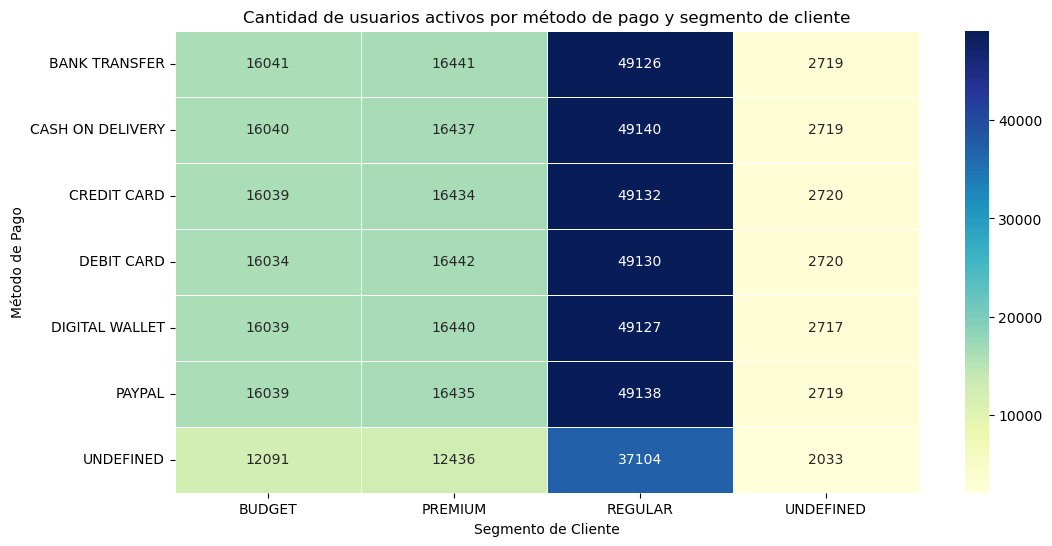

In [17]:
client_by_payment_segment = orders_customers_grouped['Total de usuarios activos'].unstack()
plt.figure(figsize=(12, 6))
plt.title('Cantidad de usuarios activos por método de pago y segmento de cliente')
sns.heatmap(client_by_payment_segment, annot=True, fmt=".0f", cmap="YlGnBu", linecolor="white", linewidths=0.6)

### 4. Para los productos que contienen en su descripción la palabra "stuff",
### calcular el peso total de su inventario agrupado por marca,
### mostrar sólo la marca y el peso total de las 5 más pesadas

In [ ]:
products["description"] = products["description"].fillna("")
stuff_products = products.loc[products["description"].str.contains("STUFF", case=False)][["product_id", "brand", "weight_kg"]]

### Reason y Movement type

In [ ]:
inventory_logs = normalize_string_column_values(inventory_logs, "reason")
inventory_logs = normalize_string_column_values(inventory_logs, "movement_type")

reason
THEFT         52096
SALE          52093
PURCHASE      52092
ADJUSTMENT    52079
RETURN        51889
TRANSFER      51852
DAMAGE        51825
UNDEFINED     12143
Name: count, dtype: int64

In [48]:
inventory_logs.groupby(["movement_type", "reason"]).size().unstack()

reason,ADJUSTMENT,DAMAGE,PURCHASE,RETURN,SALE,THEFT,TRANSFER,UNDEFINED
movement_type,,,,,,,,
ADJUSTMENT,15644,15628,15971,15814,15893,15727,15821,3700
IN,15723,15727,15812,15710,15931,15773,15559,3639
OUT,15983,15827,15643,15648,15702,15852,15809,3713
UNDEFINED,1525,1549,1581,1607,1546,1590,1582,347


In [5]:
categories = normalize_string_column_values(categories, "category_name")
categories = normalize_string_column_values(categories, "parent_category")
category_names = categories[["category_id", "category_name", "parent_category"]]
category_names = category_names.fillna("UNDEFINED")
products = products.merge(category_names, on="category_id", how="left")

In [8]:
products.groupby(["parent_category", "category_name"]).size()

parent_category  category_name   
ART_&_CRAFTS     BEADING              5491
                 CANVAS_&_PAPER       5651
                 DRAWING_SUPPLIES     5586
                 PAINTS               5503
                 PAPER_CRAFTS         5534
                                     ...  
UNDEFINED        STAMPS               5489
                 SUPPLEMENTS          5525
                 TABLETS              5594
                 TRAINING             5417
                 UNDEFINED           16754
Length: 174, dtype: int64

In [12]:
orders["order_date"] = pd.to_datetime(orders["order_date"], format="%Y-%m-%dT%H:%M:%S.%f", errors="coerce").dt.date
orders["year"] = pd.DatetimeIndex(orders["order_date"]).year
orders["month"] = pd.DatetimeIndex(orders["order_date"]).month
orders["year_month"] = pd.to_datetime(orders[["year", "month"]].assign(day=1)).dt.strftime('%Y-%m')

Text(0, 0.5, 'Cantidad de órdenes')

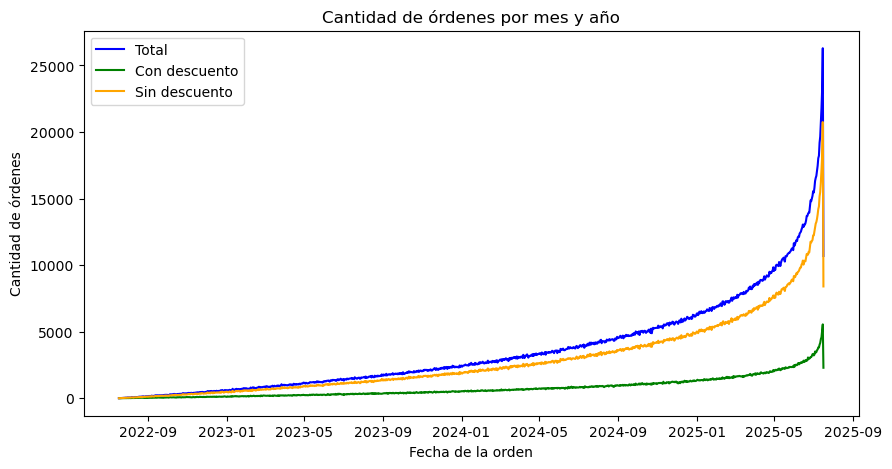

In [42]:
plt.figure(figsize=(10, 5))
plt.title("Cantidad de órdenes por mes y año")
sns.lineplot(
    data=orders["order_date"].value_counts().reset_index(), 
    x="order_date", y="count", color="blue", label="Total")
sns.lineplot(
    data=orders.loc[orders["discount_amount"] > 0]["order_date"].value_counts().reset_index(), 
    x="order_date", y="count", color="green", label="Con descuento")
sns.lineplot(
    data=orders.loc[orders["discount_amount"] == 0]["order_date"].value_counts().reset_index(), 
    x="order_date", y="count", color="orange", label="Sin descuento")
plt.xlabel("Fecha de la orden")
plt.ylabel("Cantidad de órdenes")

/tmp/ipykernel_32158/822309071.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=orders_per_state_year_month, x="month", y="count", hue="state", ci=None)


<Axes: xlabel='month', ylabel='count'>

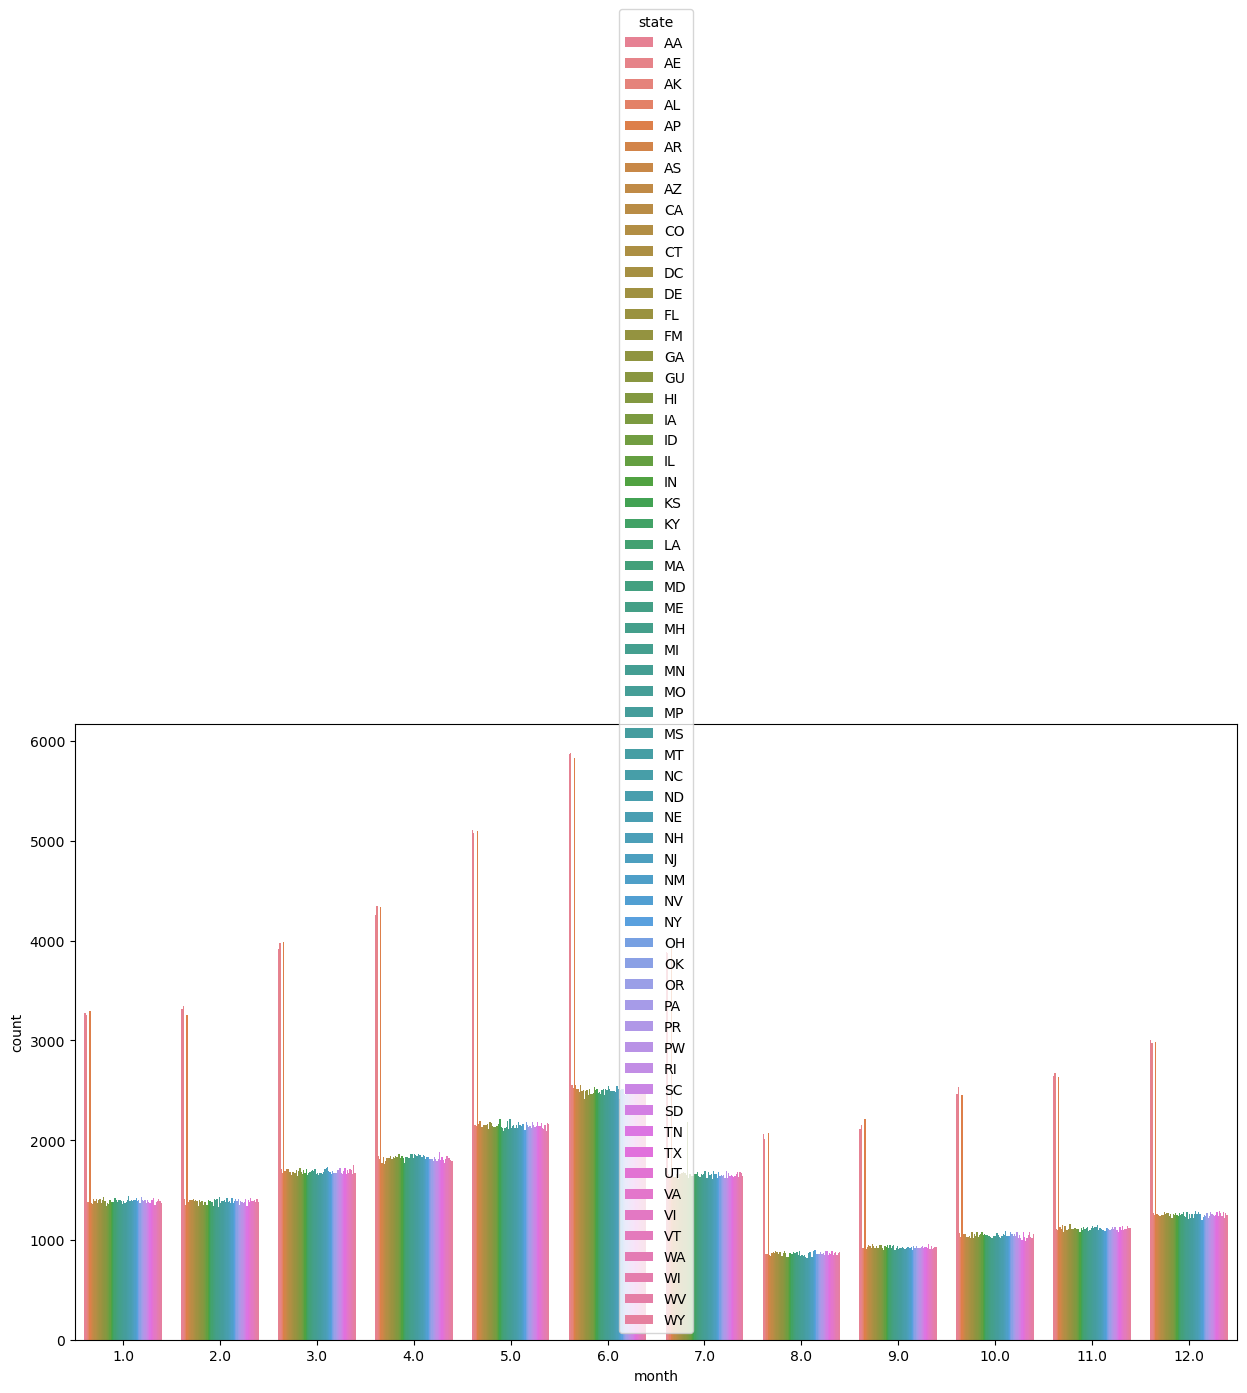

In [ ]:
orders_per_state_year_month = orders.groupby(["state","year", "month"]).size().reset_index().rename(columns={0: "count"})
plt.figure(figsize=(15, 8))
sns.barplot(data=orders_per_state_year_month, x="month", y="count", hue="state")